In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
from tqdm import tqdm
import os
import data_utils
import model_utils
from attack_utils import get_CSMIA_case_by_case_results, CSMIA_attack, LOMIA_attack
from data_utils import oneHotCatVars, filter_random_data_by_conf_score
from vulnerability_score_utils import get_vulnerability_score, draw_hist_plot
from experiment_utils import MIAExperiment
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
import pickle
# import utils
import copy

import matplotlib as mpl

# Setting the font family, size, and weight globally
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.weight'] = 'light'

In [4]:
experiments = { f"corr_btn_sens_and_out_{(i, j)}":  MIAExperiment(sampling_condition_dict = 
    {
            'correlation': 0,
            'subgroup_col_name': 'ETHNICITY',
            'marginal_prior': 1,
            # 'train_set_size_when_sampled_conditionally': 10000,
            'corr_btn_sens_and_output_per_subgroup': (i, j),
            # 'fixed_corr_in_test_data': True
    }, shortname = f"Corr_btn_sens_and_output_for_male_({i})_for_female_({j})", name='Texas100', sensitive_column='SEX_CODE'
) for (i, j) in [(k, k) for k in [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2][:]]}
# ) for i in [-0.4, -0.3, -0.2, -0.1, 0][:1] for j in [-0.4, -0.3, -0.2, -0.1, 0][3:4]}

[0, 1]
{0: {(0, 1): 3125, (0, 0): 9375, (1, 1): 9375, (1, 0): 3125}, 1: {(0, 1): 3125, (0, 0): 9375, (1, 1): 9375, (1, 0): 3125}}


100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  5.30it/s]


[0, 1]
{0: {(0, 1): 3437, (0, 0): 9062, (1, 1): 9063, (1, 0): 3438}, 1: {(0, 1): 3437, (0, 0): 9062, (1, 1): 9063, (1, 0): 3438}}


100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  5.23it/s]


[0, 1]
{0: {(0, 1): 3750, (0, 0): 8750, (1, 1): 8750, (1, 0): 3750}, 1: {(0, 1): 3750, (0, 0): 8750, (1, 1): 8750, (1, 0): 3750}}


100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  5.23it/s]


[0, 1]
{0: {(0, 1): 4062, (0, 0): 8437, (1, 1): 8438, (1, 0): 4063}, 1: {(0, 1): 4062, (0, 0): 8437, (1, 1): 8438, (1, 0): 4063}}


100%|██████████| 2/2 [00:00<00:00,  4.76it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  5.14it/s]


[0, 1]
{0: {(0, 1): 4375, (0, 0): 8125, (1, 1): 8125, (1, 0): 4375}, 1: {(0, 1): 4375, (0, 0): 8125, (1, 1): 8125, (1, 0): 4375}}


100%|██████████| 2/2 [00:00<00:00,  4.73it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  4.42it/s]


[0, 1]
{0: {(0, 1): 4687, (0, 0): 7812, (1, 1): 7813, (1, 0): 4688}, 1: {(0, 1): 4687, (0, 0): 7812, (1, 1): 7813, (1, 0): 4688}}


100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  4.92it/s]


[0, 1]
{0: {(0, 1): 5000, (0, 0): 7500, (1, 1): 7500, (1, 0): 5000}, 1: {(0, 1): 5000, (0, 0): 7500, (1, 1): 7500, (1, 0): 5000}}


100%|██████████| 2/2 [00:00<00:00,  4.71it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  5.28it/s]


In [6]:
save_model = True

for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(f"Training classifier for experiment: {experiment}")
    try:
        experiment.clf_only_on_test = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model_only_on_test_dummy.pkl')
        print(f"Loaded classifier for experiment from file: {experiment}")
    except:
        # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
        base_model = model_utils.get_model(max_iter=500)
        experiment.clf_only_on_test = copy.deepcopy(base_model)
        experiment.clf_only_on_test.fit(experiment.X_test, experiment.y_te_onehot)

        if save_model:
            model_utils.save_model(experiment.clf_only_on_test, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model_only_on_test_dummy.pkl')

Training classifier for experiment: Texas100_correlation_0_subgroup_col_name_ETHNICITY_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN0.5, 0.5RPAREN
Loaded classifier for experiment from file: Texas100_correlation_0_subgroup_col_name_ETHNICITY_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN0.5, 0.5RPAREN
Training classifier for experiment: Texas100_correlation_0_subgroup_col_name_ETHNICITY_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN0.45, 0.45RPAREN
Loaded classifier for experiment from file: Texas100_correlation_0_subgroup_col_name_ETHNICITY_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN0.45, 0.45RPAREN
Training classifier for experiment: Texas100_correlation_0_subgroup_col_name_ETHNICITY_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN0.4, 0.4RPAREN
Loaded classifier for experiment from file: Texas100_correlation_0_subgroup_col_name_ETHNICITY_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN0.4, 0.4R

In [7]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    experiment.original_df = experiment.ds.ds.original_df[experiment.ds.ds.original_df['is_train']==0]
    experiment.original_df = experiment.original_df.drop(['is_train'], axis=1)
    experiment.aux_df = experiment.ds.ds.original_df[experiment.ds.ds.original_df['is_train']==1]
    experiment.aux_df = experiment.aux_df.drop(['is_train'], axis=1)
    experiment.y_column = experiment.ds.ds.meta['y_column']

In [8]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    sens_pred, case_indices = CSMIA_attack(experiment.clf_only_on_test, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)
    experiment.correct_indices = (sens_pred == experiment.X_test[[f'{experiment.ds.ds.meta["sensitive_column"]}_1']].to_numpy().ravel())
    experiment.incorrect_indices = ~experiment.correct_indices
    experiment.sensitive_column = experiment.ds.ds.meta["sensitive_column"]

In [32]:
experiment.ds.ds.original_df.columns

Index(['SEX_CODE', 'TYPE_OF_ADMISSION', 'SOURCE_OF_ADMISSION',
       'LENGTH_OF_STAY', 'PAT_AGE', 'PAT_STATUS', 'RACE', 'ETHNICITY',
       'TOTAL_CHARGES', 'ADMITTING_DIAGNOSIS', 'PRINC_SURG_PROC_CODE',
       'is_train'],
      dtype='object')

In [9]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    try:
        experiment.all_vuln_scores = np.load(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_vuln_scores.npy')
    except:
        experiment.all_vuln_scores = np.array([get_vulnerability_score(experiment, experiment.X_test, experiment.y_te, experiment.original_df, index, k=4) for index in tqdm(experiment.X_test.index)])
        np.save(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_vuln_scores.npy', experiment.all_vuln_scores)
    experiment.all_vuln_scores_rounded = np.round(experiment.all_vuln_scores)
    experiment.vuln_accuracy = accuracy_score(experiment.correct_indices, experiment.all_vuln_scores_rounded)

In [10]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    sens_pred_LOMIA = LOMIA_attack(experiment, experiment.clf_only_on_test, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)
    experiment.correct_indices_LOMIA = (sens_pred_LOMIA == experiment.X_test[[f'{experiment.ds.ds.meta["sensitive_column"]}_1']].to_numpy().ravel())
    experiment.incorrect_indices_LOMIA = ~experiment.correct_indices_LOMIA
    experiment.vuln_accuracy_LOMIA = accuracy_score(experiment.correct_indices_LOMIA, experiment.all_vuln_scores_rounded)

In [11]:
from disparity_inference_utils import get_corr_btn_sens_and_out_per_subgroup

def false_positive_rate(x, y):
    tp, fn, fp, tn = confusion_matrix(x, y).ravel()
    return round(fp / (fp + tn), 4)

eval_func = {
    'precision': precision_score,
    'recall': recall_score,
    'f1': f1_score,
    'accuracy': accuracy_score,
    'fpr': false_positive_rate
}
performance_dict = {}
for metric in eval_func:
    performance_dict[metric] = {}
    for experiment_key in experiments:
        experiment = experiments[experiment_key]
        correlation = round(get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_test, experiment.y_te, {}), 2)
        # print(experiment.sampling_condition_dict['corr_btn_sens_and_output_per_subgroup'])
        CSMIA_performance = 100 * eval_func[metric](experiment.correct_indices, experiment.all_vuln_scores_rounded)
        LOMIA_performance = 100 * eval_func[metric](experiment.correct_indices_LOMIA, experiment.all_vuln_scores_rounded)
        performance_dict[metric][correlation] = {
            'CSMIA': CSMIA_performance,
            'LOMIA': LOMIA_performance
        }

In [1]:
import matplotlib.pyplot as plt

In [18]:
mpl.rcParams['font.family'] = 'Avenir'
mpl.rcParams['font.size'] = 18

def plot_result(performance_dict, metric='accuracy', save_fig=False):
    attacks = ['CSMIA', 'LOMIA']
    metric_name_dict = {'accuracy': 'Risk Prediction Accuracy', 'f1': 'F1 Score', 'fpr': 'False Positive Rate', 'precision': 'Precision', 'recall': 'Recall'}
    df = pd.DataFrame.from_dict(performance_dict[metric], orient='index')
    fig, ax = plt.subplots(figsize=(6, 4.5))
    line_styles = ['-', '--', '-.', ':']
    colors = ['#000000', '#4D4D4D', '#7F7F7F', '#BFBFBF']  # Different shades of black/gray
    markers = ['o', 's', '^', 'd']  # Circle, square, triangle up, diamond
    for i, attack in enumerate(attacks):
        plt.plot(df.index, df[f'{attack}'], label=attack, marker=markers[i], linestyle=line_styles[i], color=colors[i], markersize=5)
    extra = Line2D([0], [0], color='white', label='Census19\n\n\n')

    # Create legend with custom entry
    handles, labels = plt.gca().get_legend_handles_labels()
    # handles.append(extra)
    # labels.append('Census19')
    handles = [extra]+handles
    labels = ['Texas-100X'] + labels

    # Create legend with custom entry
    plt.legend(handles=handles, labels=labels, loc='lower left')
    # plt.legend()
    plt.xlabel('Correlation')
    plt.ylabel(metric_name_dict[metric])
    plt.ylim(0, 100)
    plt.grid(True, linewidth=0.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if save_fig:

        # plt.gcf().subplots_adjust(bottom=0.15)

        # # alternate option without .gcf
        plt.subplots_adjust(bottom=0.15)
        plt.savefig(f'vuln_scores_{metric}_{experiment.ds.ds.name}.png')
    else:
        plt.show()

In [16]:
from matplotlib.lines import Line2D

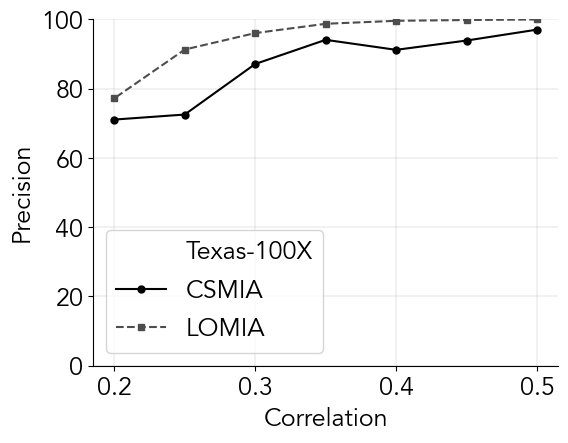

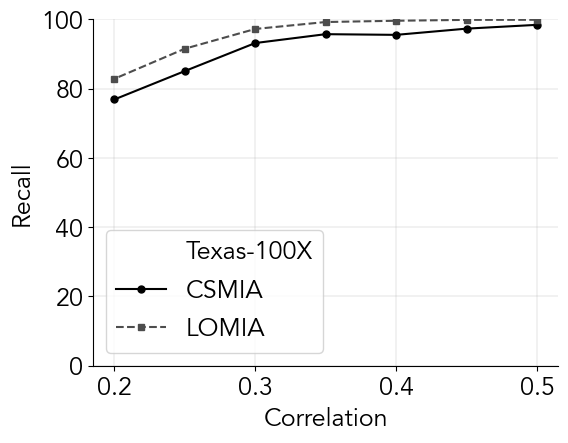

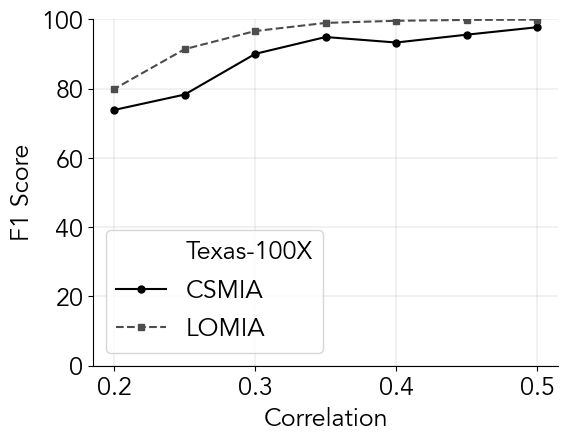

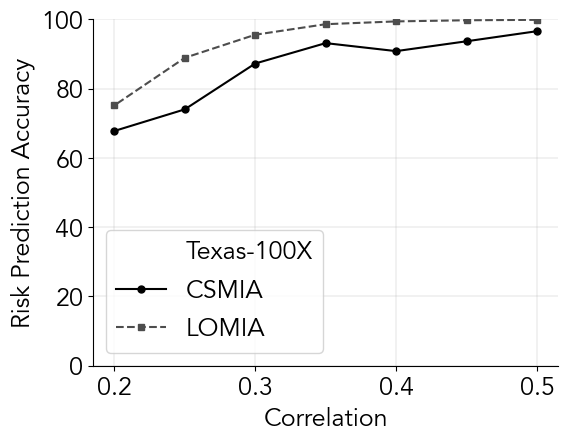

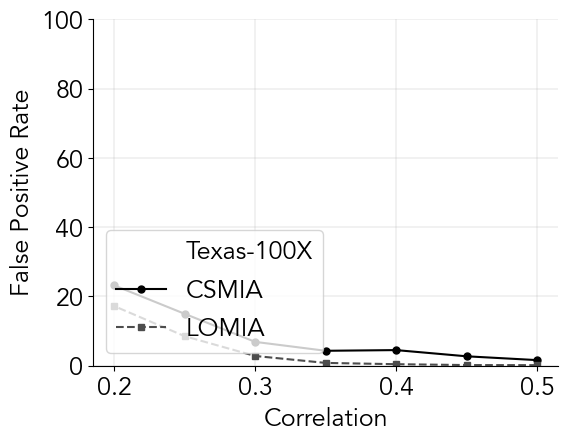

In [19]:
for metric in eval_func:
    plot_result(performance_dict, metric=metric, save_fig=False)

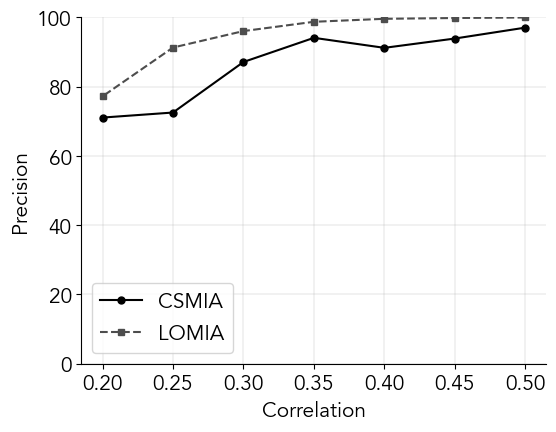

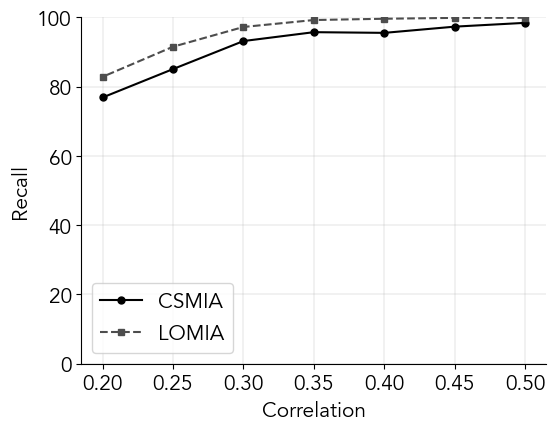

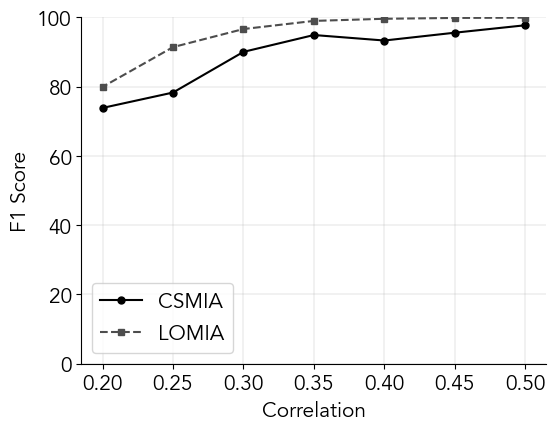

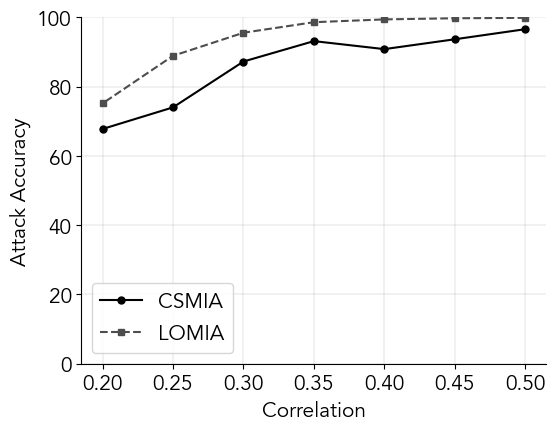

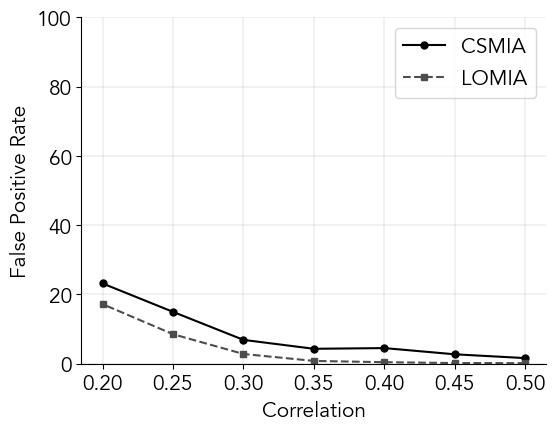

In [20]:
for metric in eval_func:
    plot_result(performance_dict, metric=metric, save_fig=False)

In [11]:
print(vuln_accuracies_CSMIA)
print(vuln_accuracy_LOMIA)

[0.96548, 0.93636, 0.90794, 0.93104, 0.87216, 0.73982, 0.67744]
[0.99822, 0.99698, 0.99372, 0.98564, 0.95522, 0.88858, 0.75118]


In [10]:
vuln_accuracies_CSMIA = [experiments[experiment_key].vuln_accuracy for experiment_key in experiments]
vuln_accuracy_LOMIA = [experiments[experiment_key].vuln_accuracy_LOMIA for experiment_key in experiments]
corrs = [-0.4, -0.35, -0.3, -0.25, -0.2]


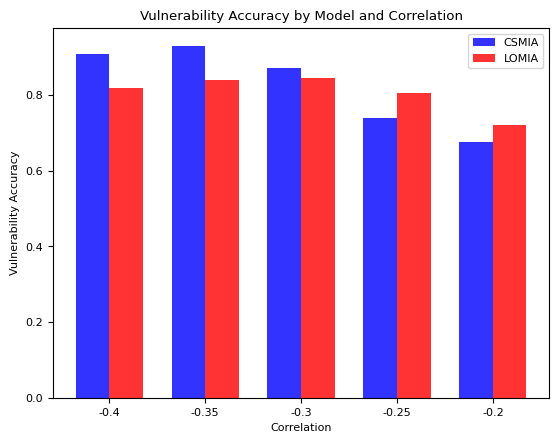

In [27]:
n_groups = len(corrs)

# Create figure and axis
fig, ax = plt.subplots()

# Index for the groups
index = np.arange(n_groups)

# Bar width
bar_width = 0.35

# Opacity for the bars
opacity = 0.8

# Plotting
rects1 = ax.bar(index, vuln_accuracies_CSMIA, bar_width,
                alpha=opacity, color='b',
                label='CSMIA')

rects2 = ax.bar(index + bar_width, vuln_accuracy_LOMIA, bar_width,
                alpha=opacity, color='r',
                label='LOMIA')

# Adding labels, title and axes ticks
ax.set_xlabel('Correlation')
ax.set_ylabel('Vulnerability Accuracy')
ax.set_title('Vulnerability Accuracy by Model and Correlation')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(corrs)
ax.legend()

# Show the plot
plt.show()

# add bar for attack performance

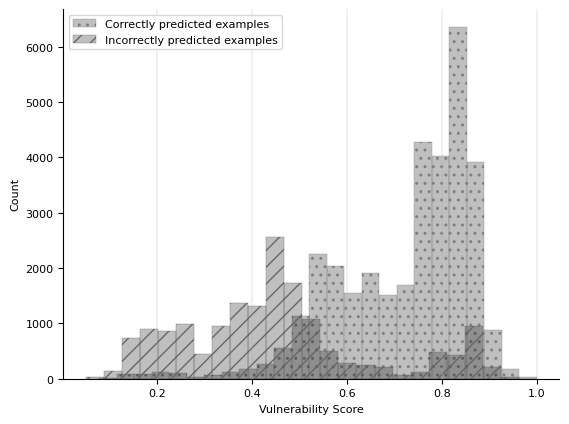

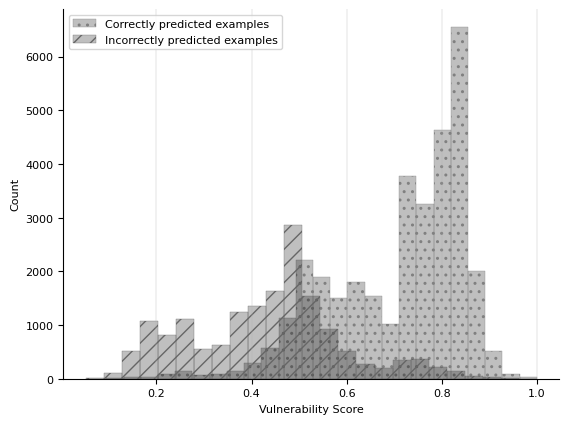

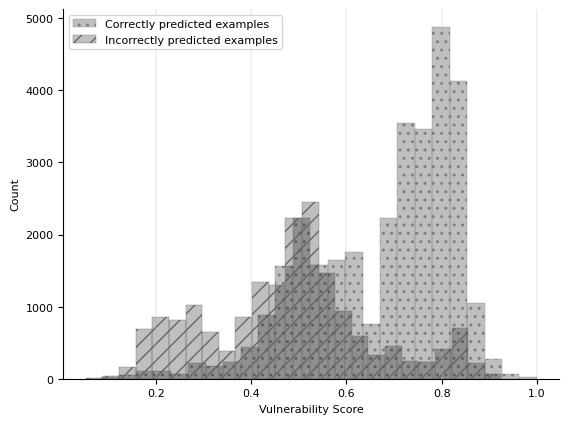

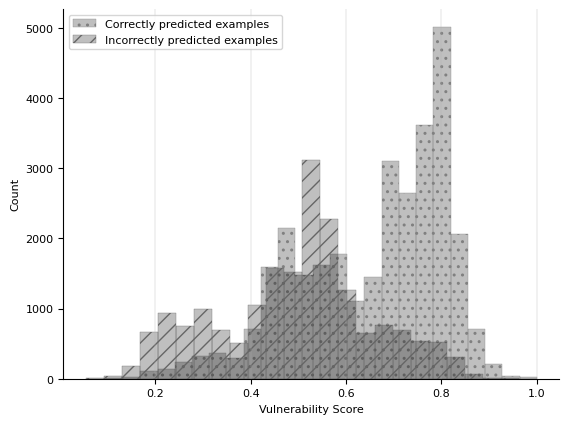

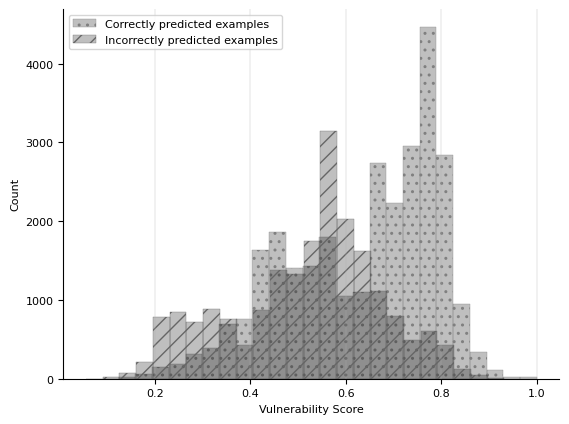

In [28]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    draw_hist_plot(experiment.all_vuln_scores, experiment.correct_indices, experiment.incorrect_indices)
    plt.show()

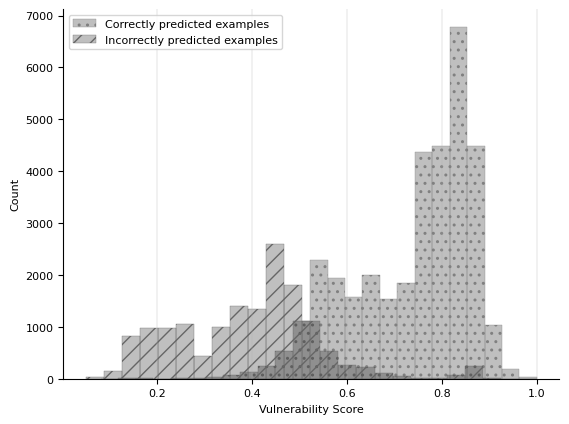

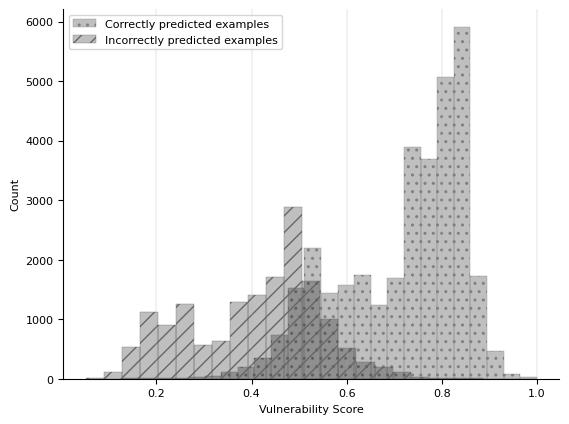

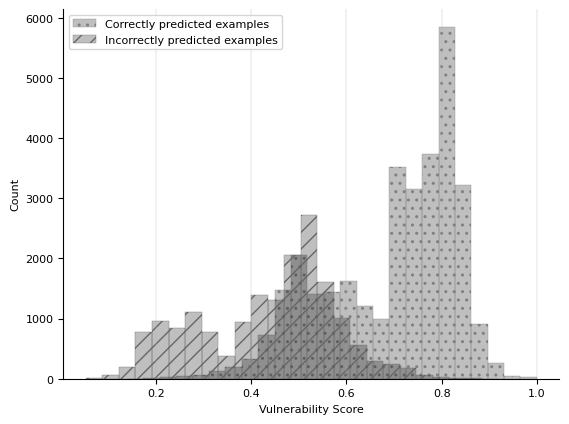

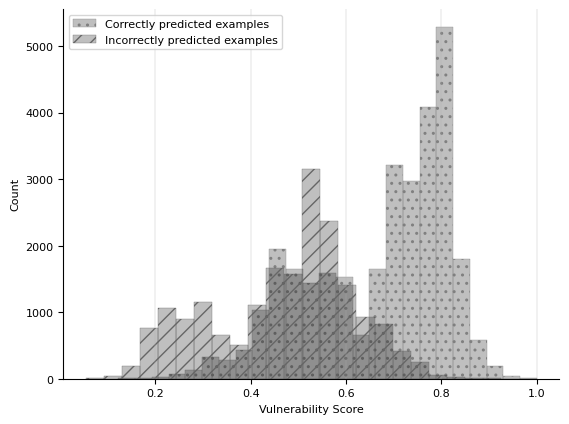

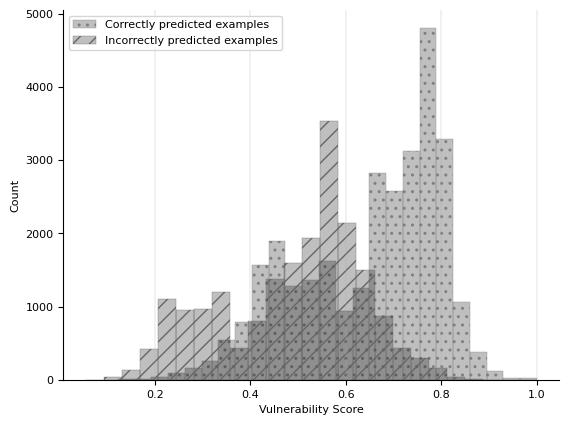

In [29]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    draw_hist_plot(experiment.all_vuln_scores, experiment.correct_indices_LOMIA, experiment.incorrect_indices_LOMIA)
    plt.show()

In [27]:
# Setting the font family, size, and weight globally
mpl.rcParams['font.family'] = 'Avenir' # Avenir, Optima, Lucida Grande, Trebuchet MS, Gill Sans
mpl.rcParams['font.size'] = 10
mpl.rcParams['font.weight'] = 'regular'

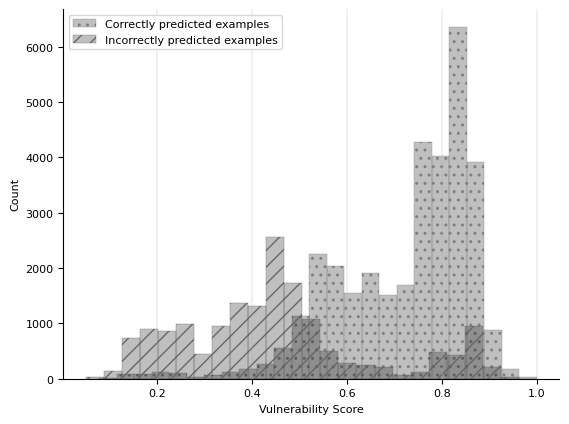

In [92]:
draw_hist_plot(all_vuln_scores, correct_indices, incorrect_indices)

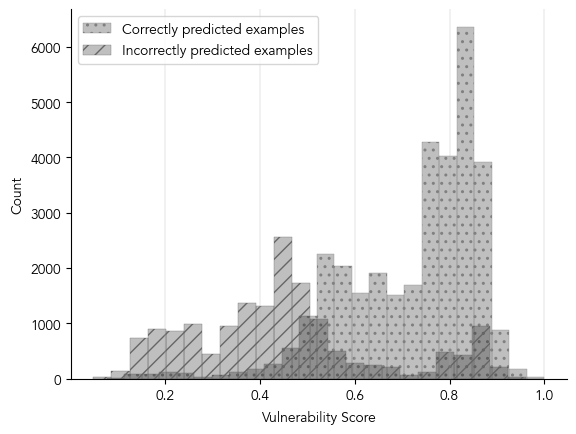

In [88]:
fig, ax = plt.subplots()
sns.histplot(all_vuln_scores[correct_indices], label='Correctly predicted examples', element='bars', stat='count', bins=25, linewidth=0.25, alpha=0.5, color="grey", hatch='..', edgecolor='grey')
# sns.histplot(all_vuln_scores[correct_indices], label='Correctly predicted examples', element='bars', stat='count', bins=25, linewidth=0, alpha=0.01, color=(0, 0, 0, 0), hatch='..', edgecolor='grey')
sns.histplot(all_vuln_scores[incorrect_indices], label='Incorrectly predicted examples', element='bars', stat='count', bins=25, linewidth=0.25, alpha=0.25, color="black", hatch='//', edgecolor=(0.4, 0.4, 0.4))
plt.xlabel('Vulnerability Score')
plt.ylabel('Count')
plt.grid(True, linestyle='-', linewidth=0.25, axis='x')
# plt.title('Distribution of Predicted neighborhood similarity among k=4 dist neighbours from synthetic data for case 1 examples')
# plt.legend()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
sns.despine()
plt.show()

In [18]:
all_vuln_scores_rounded = np.round(all_vuln_scores)

In [19]:
accuracy_score(correct_indices, all_vuln_scores_rounded)

0.86338

In [21]:
from sklearn.metrics import RocCurveDisplay

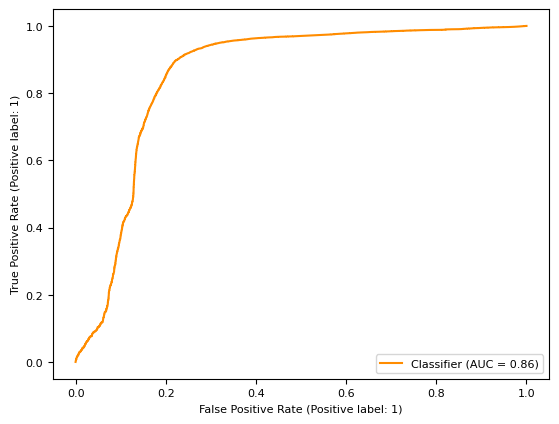

In [26]:
RocCurveDisplay.from_predictions(correct_indices, all_vuln_scores, pos_label=1, 
    color="darkorange")

In [111]:
all_vuln_scores_aux = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_train, experiment.y_tr, aux_df, index, k=4) for index in experiment.X_train.index])

In [112]:
np.save(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_vuln_scores_aux.pkl', all_vuln_scores_aux)

In [18]:
np.load(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_vuln_scores_aux.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '<PATH_TO_MODEL>/Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.4, -0.4RPAREN_vuln_scores_aux.pkl'

In [115]:
aux_df_onehot = experiment.ds.ds.df.copy()

aux_df_onehot = aux_df_onehot[aux_df_onehot["is_train"]==1].drop("is_train", axis=1)

In [118]:
all_vuln_scores_rounded_aux = np.round(all_vuln_scores_aux)

In [122]:
X_attack, y_sens = experiment.ds.ds.get_attack_df(aux_df_onehot)
X_attack = X_attack.astype(float)
vuln_clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(64, 32, 16, 8))
vuln_clf.fit(X_attack, all_vuln_scores_rounded_aux)

MLPClassifier(hidden_layer_sizes=(64, 32, 16, 8), max_iter=500, random_state=42)

In [123]:
acc = 100 * vuln_clf.score(X_attack, all_vuln_scores_rounded_aux)
print(f'Inverse accuracy with test size : {acc}')

Inverse accuracy with test size : 78.29


In [149]:
original_df_onehot = experiment.ds.ds.df.copy()

original_df_onehot = original_df_onehot[original_df_onehot["is_train"]==0].drop("is_train", axis=1).reset_index(drop=True)

In [126]:
X_attack_orig, _ = experiment.ds.ds.get_attack_df(original_df_onehot)
X_attack_orig = X_attack_orig.astype(float)

In [127]:
vuln_preds = vuln_clf.predict(X_attack_orig)

In [132]:
(vuln_preds==correct_indices).mean()

0.65362

In [156]:
aux_samp_from_orig = np.random.choice(original_df_onehot.index, 5000, False)

In [157]:
aux_from_orig_onehot = original_df_onehot.iloc[aux_samp_from_orig]
X_attack_aux_from_orig, _ = experiment.ds.ds.get_attack_df(aux_from_orig_onehot)
X_attack_aux_from_orig = X_attack_aux_from_orig.astype(float)
vuln_scores_aux_from_orig = all_vuln_scores_rounded_aux[aux_samp_from_orig]

In [158]:
vuln_clf_w_5000 = model_utils.get_model(max_iter=500, hidden_layer_sizes=(64, 32, 16, 8), verbose=True, learning_rate='adaptive')
vuln_clf_w_5000.fit(X_attack_aux_from_orig, vuln_scores_aux_from_orig)

Iteration 1, loss = 0.67614468
Iteration 2, loss = 0.63750032
Iteration 3, loss = 0.63327052
Iteration 4, loss = 0.63058656
Iteration 5, loss = 0.62783505
Iteration 6, loss = 0.62579345
Iteration 7, loss = 0.62300825
Iteration 8, loss = 0.61967103
Iteration 9, loss = 0.61685222
Iteration 10, loss = 0.61173342
Iteration 11, loss = 0.60660021
Iteration 12, loss = 0.60196004
Iteration 13, loss = 0.59636308
Iteration 14, loss = 0.59010240
Iteration 15, loss = 0.58234509
Iteration 16, loss = 0.57310863
Iteration 17, loss = 0.56525822
Iteration 18, loss = 0.55597277
Iteration 19, loss = 0.54657120
Iteration 20, loss = 0.53803313
Iteration 21, loss = 0.52475907
Iteration 22, loss = 0.52119457
Iteration 23, loss = 0.51065466
Iteration 24, loss = 0.49937228
Iteration 25, loss = 0.48931758
Iteration 26, loss = 0.47608382
Iteration 27, loss = 0.46637647
Iteration 28, loss = 0.45470315
Iteration 29, loss = 0.45163349
Iteration 30, loss = 0.43971565
Iteration 31, loss = 0.44285496
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(64, 32, 16, 8), learning_rate='adaptive',
              max_iter=500, random_state=42, verbose=True)

In [154]:
vuln_preds_ver_2 = vuln_clf.predict(X_attack_orig)

In [155]:
(vuln_preds_ver_2==correct_indices).mean()

0.70222

In [159]:
vuln_preds_ver_3 = vuln_clf_w_5000.predict(X_attack_orig)

In [1]:
(vuln_preds_ver_3==correct_indices).mean()

NameError: name 'vuln_preds_ver_3' is not defined

In [67]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 1
k = 4
perc_same_sens_val_correct = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, original_df, index, k=4) for index in case_2_correct_indices[:]])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, original_df, index, k=4) for index in case_2_incorrect_indices[:]])

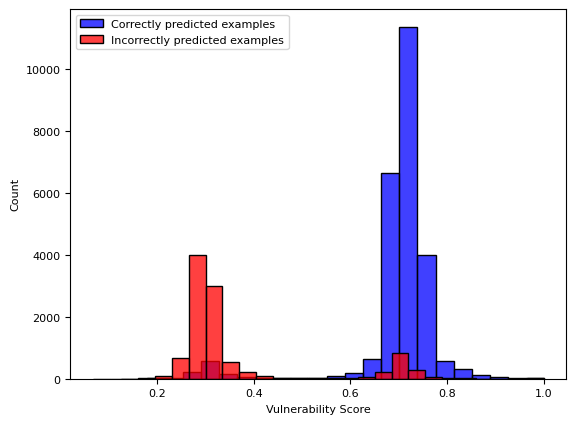

In [68]:
# sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
# sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
sns.histplot(perc_same_sens_val_correct, label='Correctly predicted examples', color='blue', element='bars', stat='count', bins=25)
sns.histplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples', color='red', element='bars', stat='count', bins=25)
plt.xlabel('Vulnerability Score')
plt.ylabel('Count')
# plt.title('Distribution of Predicted neighborhood similarity among k=4 dist neighbours from synthetic data for case 1 examples')
plt.legend()
plt.show()

In [44]:
index = case_2_incorrect_indices[400]

print(get_mean_confidence_distance_among_dist_k_neighbours_in_aux_data(experiment.X_test, experiment.y_te, original_df, original_df, sens_pred[index], experiment.y_te[index], index, k=5))

0.08781601583668741


In [45]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 1
k = 4
perc_same_sens_val_correct = np.array([get_mean_confidence_distance_among_dist_k_neighbours_in_aux_data(experiment.X_test, experiment.y_te, original_df, original_df, sens_pred[index], experiment.y_te[index], index, k=k) for index in case_1_correct_indices[:]])
perc_same_sens_val_incorrect = np.array([get_mean_confidence_distance_among_dist_k_neighbours_in_aux_data(experiment.X_test, experiment.y_te, original_df, original_df, sens_pred[index], experiment.y_te[index], index, k=k) for index in case_1_incorrect_indices[:]])

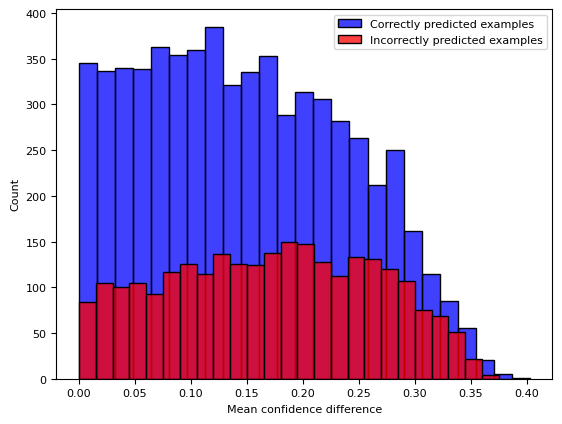

In [46]:
# sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
# sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
sns.histplot(perc_same_sens_val_correct, label='Correctly predicted examples', color='blue', element='bars', stat='count', bins=25)
sns.histplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples', color='red', element='bars', stat='count', bins=25)
plt.xlabel('Mean confidence difference')
plt.ylabel('Count')
# plt.title('Distribution of Predicted neighborhood similarity among k=4 dist neighbours from synthetic data for case 1 examples')
plt.legend()
plt.show()

In [97]:
index = case_2_correct_indices[0]

print(get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(experiment.X_random, experiment.y_random, original_df, experiment.X_random_df, sens_pred[index], experiment.y_te[index], index, k=5))

0.8181818181818182


In [98]:
index = case_2_incorrect_indices[0]

print(get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(experiment.X_random, experiment.y_random, original_df, experiment.X_random_df, sens_pred[index], experiment.y_te[index], index, k=5))

0.9588014981273408


In [99]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 1
k = 4
perc_same_sens_val_correct = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(experiment.X_random, experiment.y_random, original_df, experiment.X_random_df, sens_pred[index], experiment.y_te[index], index, k=5) for index in case_1_correct_indices[:]])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(experiment.X_random, experiment.y_random, original_df, experiment.X_random_df, sens_pred[index], experiment.y_te[index], index, k=5) for index in case_1_incorrect_indices[:]])

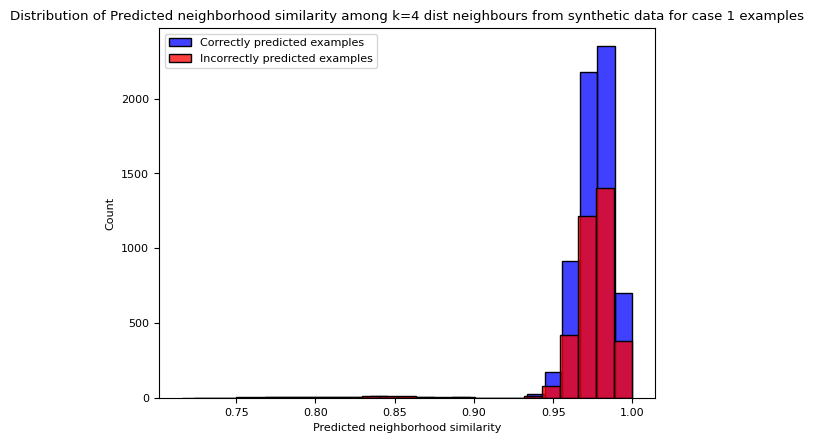

In [100]:
# sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
# sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
sns.histplot(perc_same_sens_val_correct, label='Correctly predicted examples', color='blue', element='bars', stat='count', bins=25)
sns.histplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples', color='red', element='bars', stat='count', bins=25)
plt.xlabel('Predicted neighborhood similarity')
plt.ylabel('Count')
plt.title('Distribution of Predicted neighborhood similarity among k=4 dist neighbours from synthetic data for case 1 examples')
plt.legend()
plt.show()

In [126]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 2
k = 4
perc_same_sens_val_correct = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(experiment.X_train, experiment.y_tr, original_df, aux_df, sens_pred[index], experiment.y_te[index], index, k=4) for index in case_2_correct_indices[:]])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(experiment.X_train, experiment.y_tr, original_df, aux_df, sens_pred[index], experiment.y_te[index], index, k=4) for index in case_2_incorrect_indices[:]])

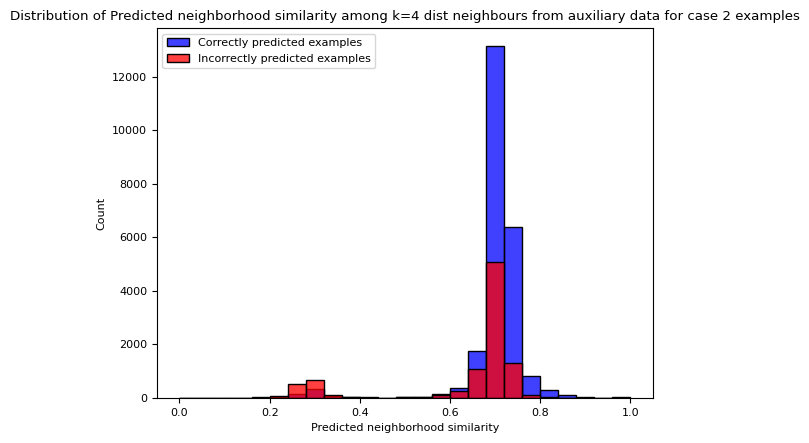

In [127]:
# sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
# sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
sns.histplot(perc_same_sens_val_correct, label='Correctly predicted examples', color='blue', element='bars', stat='count', bins=25)
sns.histplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples', color='red', element='bars', stat='count', bins=25)
plt.xlabel('Predicted neighborhood similarity')
plt.ylabel('Count')
plt.title('Distribution of Predicted neighborhood similarity among k=4 dist neighbours from auxiliary data for case 2 examples')
plt.legend()
plt.show()

In [101]:
temp_df = original_df.iloc[:5]

In [102]:
temp_df

,AGEP,COW,SCHL,MAR,RAC1P,SEX,DREM,DPHY,DEAR,DEYE,WKHP,WAOB,ST,PINCP
50000,61,0,20,0,0,0,0,0,0,0,40,0,33,0
50001,67,6,23,0,0,0,0,0,0,0,40,3,9,0
50002,50,3,21,0,0,0,0,0,0,0,40,2,9,0
50003,39,6,20,0,0,0,0,0,0,0,80,0,23,0
50004,34,0,18,0,0,0,0,0,1,0,50,0,38,0


In [106]:
temp_df.at[50000, 'MAR'] = 1

In [107]:
temp_df

,AGEP,COW,SCHL,MAR,RAC1P,SEX,DREM,DPHY,DEAR,DEYE,WKHP,WAOB,ST,PINCP
50000,61.0,0.0,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,33.0,0
50001,67.0,6.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,3.0,9.0,0
50002,50.0,3.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,2.0,9.0,0
50003,39.0,6.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,23.0,0
50004,34.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,50.0,0.0,38.0,0
0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
experiment.dist_matrix = experiment.dist_matrix.T

In [21]:
sens_pred_random, _ = CSMIA_attack(experiment.clf_only_on_test, experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.ds.ds.meta)

In [42]:
index = case_2_correct_indices[100]
get_percentage_of_neighbors_with_dominant_sens_val_pred_by_CSMIA_among_dist_k_neighbours(experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.y_te[index], sens_pred[index], sens_pred_random, case_indices, index, k=4)

0.28294117647058825

In [43]:
index = case_2_incorrect_indices[100]
get_percentage_of_neighbors_with_dominant_sens_val_pred_by_CSMIA_among_dist_k_neighbours(experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.y_te[index], sens_pred[index], sens_pred_random, case_indices, index, k=4)

0.004201680672268907

In [32]:
case_2_correct_indices

array([    9,    16,    25, ..., 39208, 39243, 39244])

In [44]:
k = 4
perc_same_sens_val_pred_correct = np.array([get_percentage_of_neighbors_with_dominant_sens_val_pred_by_CSMIA_among_dist_k_neighbours(experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.y_te[index], sens_pred[index], sens_pred_random, case_indices, index, k=4) for index in case_2_correct_indices])
perc_same_sens_val_pred_incorrect = np.array([get_percentage_of_neighbors_with_dominant_sens_val_pred_by_CSMIA_among_dist_k_neighbours(experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.y_te[index], sens_pred[index], sens_pred_random, case_indices, index, k=4) for index in case_2_incorrect_indices])

<Axes: ylabel='Density'>

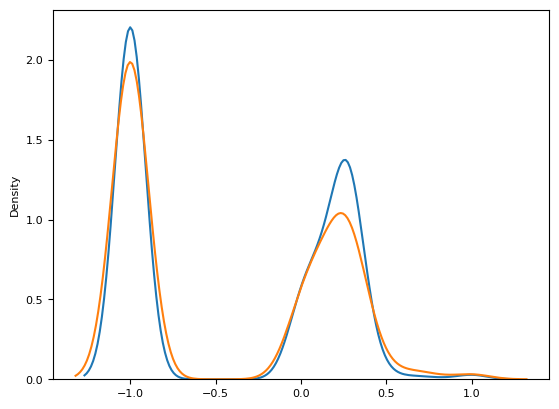

In [45]:
sns.kdeplot(perc_same_sens_val_pred_correct, label='Correctly predicted examples')
sns.kdeplot(perc_same_sens_val_pred_incorrect, label='Incorrectly predicted examples')

In [96]:
for idx in range(1):
    index = case_2_correct_indices[idx+50]
    print(get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.dist_matrix, index, 4))

1.0


In [97]:
for idx in range(1):
    index = case_2_incorrect_indices[idx+2000]
    print(get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.dist_matrix, index, 4))

0.0


In [81]:
case_2_correct_indices

array([    9,    16,    25, ..., 39208, 39243, 39244])

In [ ]:
perc_same_sens_val_correct

In [ ]:
perc_same_sens_val_incorrect

In [106]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 2
k = 4
perc_same_sens_val_correct = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.dist_matrix, index, k) for index in case_2_correct_indices[-1000:]])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.dist_matrix, index, k) for index in case_2_incorrect_indices[:1000]])

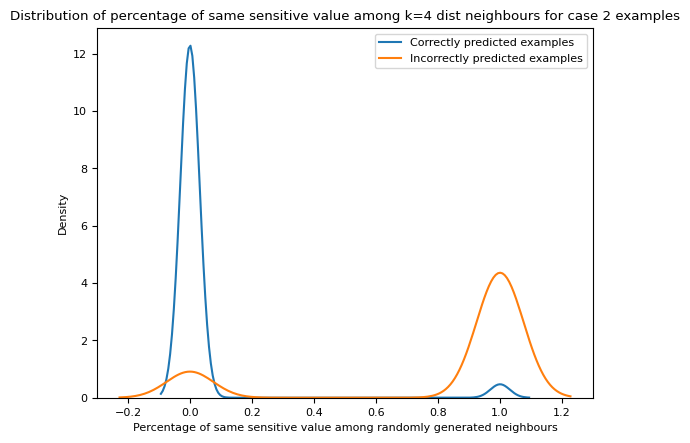

In [40]:
sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
plt.xlabel('Percentage of same sensitive value among randomly generated neighbours')
plt.ylabel('Density')
plt.title(f'Distribution of percentage of same sensitive value among k={k} dist neighbours for case 2 examples')
plt.legend()
plt.show()

In [107]:
from collections import Counter
Counter(np.nan_to_num(perc_same_sens_val_correct, nan=-1))

Counter({0.0: 774, -1.0: 226})

In [108]:
from collections import Counter
Counter(np.nan_to_num(perc_same_sens_val_incorrect, nan=-1))

Counter({1.0: 978, -1.0: 22})

In [9]:
experiment.X_random_df[['MAR', 'PINCP']].head(10)

,MAR,PINCP
5,0,0
6,1,1
7,0,0
8,0,0
9,1,0
12,1,1
14,0,0
16,1,0
18,0,0
23,0,0
